In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pymongo import MongoClient
from datetime import datetime

In [3]:
#client = MongoClient('') - connect to Mongo
#db = client['Amazone'] - choose Amazone DB

In [4]:
#convert date to the right format
target_date = datetime.strptime('2023-12-06', '%Y-%m-%d')

In [21]:
#pipeline construction
pipeline_fresh = [
    {"$unwind": "$order_items"},
    {
        "$lookup": {
            "from": "FreshProducts",
            "localField": "order_items.product_id",
            "foreignField": "_id",
            "as": "freshProduct"
        }
    },
    {"$unwind": "$freshProduct"},
    {
        "$match": {
            "freshProduct.type": {"$in": ["bakery", "fruits and vegetables", "drinks"]}
        }
    },
    {
        "$group": {
            "_id": "$freshProduct.type",
            "totalSales": {"$sum": {"$multiply": ["$order_items.quantity", "$freshProduct.standard_price"]}},
            "totalQuantity": {"$sum": "$order_items.quantity"}
        }
    },
    {
        "$lookup": {
            "from": "FreshProducts",
            "localField": "_id",
            "foreignField": "type",
            "as": "inventoryInfo"
        }
    },
    {"$unwind": "$inventoryInfo"},
    {"$unwind": "$inventoryInfo.daily_inventory_level"},
    {
        "$match": {
            "inventoryInfo.daily_inventory_level.date": target_date
        }
    },
    {
        "$project": {
            "_id": 1,
            "totalSales": 1,
            "totalQuantity": 1,
            "inventoryInfo": {
                "name": 1,
                "inventory_quantity": "$inventoryInfo.daily_inventory_level.inventory_quantity"
            }
        }
    }
]


In [22]:
#aggregation
result = list(db.PastOrders.aggregate(pipeline_fresh))

In [23]:
#save result as pandas df
df = pd.DataFrame(result)

In [24]:
print(df)

                      _id  totalSales  totalQuantity  \
0   fruits and vegetables       70.00             44   
1   fruits and vegetables       70.00             44   
2   fruits and vegetables       70.00             44   
3   fruits and vegetables       70.00             44   
4   fruits and vegetables       70.00             44   
5                  bakery      151.50            101   
6                  bakery      151.50            101   
7                  bakery      151.50            101   
8                  bakery      151.50            101   
9                  bakery      151.50            101   
10                 drinks      150.17             78   
11                 drinks      150.17             78   
12                 drinks      150.17             78   
13                 drinks      150.17             78   
14                 drinks      150.17             78   

                                        inventoryInfo  
0          {'name': 'apple', 'inventory_quantit

In [9]:
pastel_blue = (173/255, 216/255, 230/255) 
pastel_green = (173/255, 255/255, 182/255)  
pastel_yellow = (255/255, 253/255, 182/255)

In [10]:
colours = [pastel_blue, pastel_green, pastel_yellow]

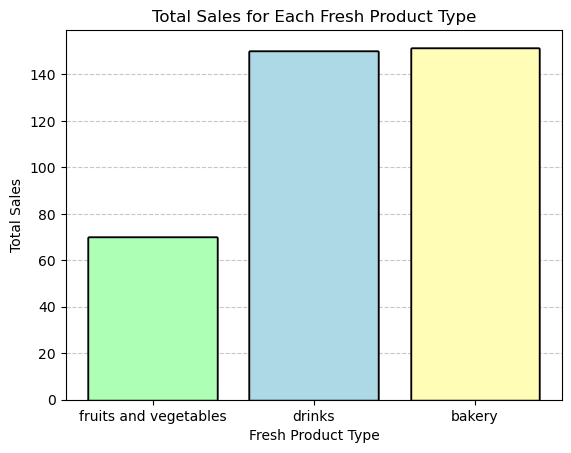

In [15]:
#plot total sales for fresh product type
plt.grid(True, axis='y', linestyle='--', alpha=0.7, zorder=1)
plt.bar(df['_id'], df['totalSales'], color=colours, zorder=2, edgecolor='black')
plt.xlabel('Fresh Product Type')
plt.ylabel('Total Sales')
plt.title('Total Sales for Each Fresh Product Type')
plt.savefig('fresh_sales_plot.png')
plt.show()

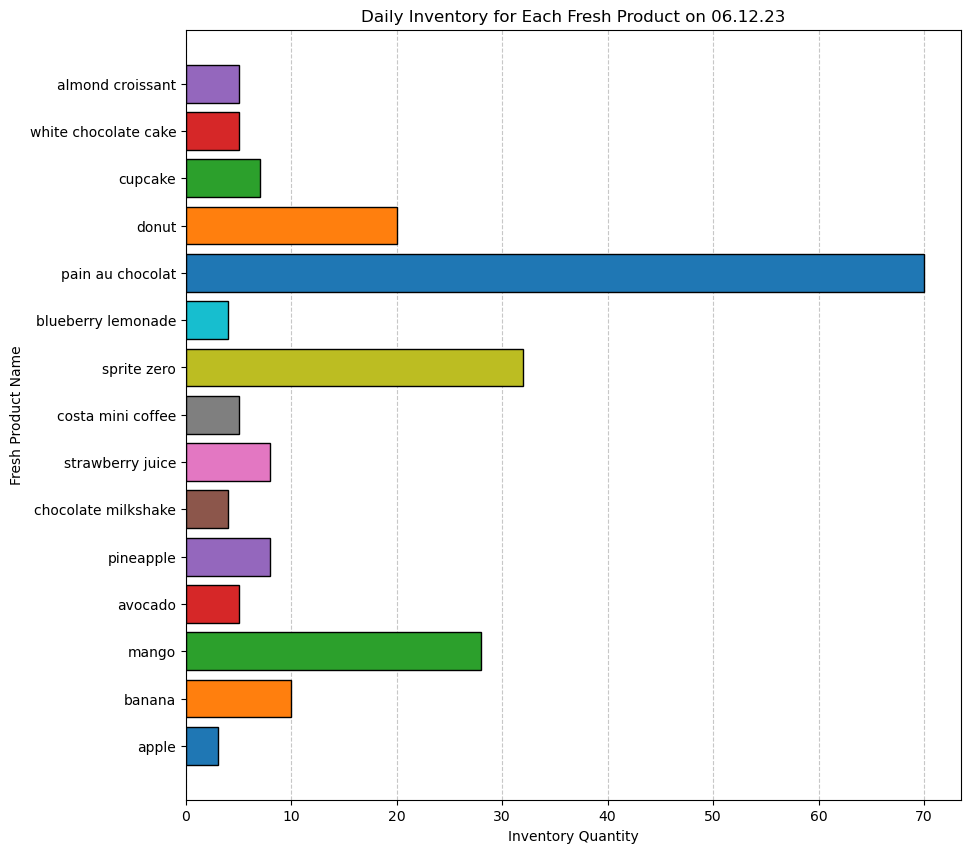

In [20]:
#plot daily inventory for 06.12 for fresh products
plt.figure(figsize=(10, 10))
for index, row in df.iterrows():
    plt.barh(row['inventoryInfo']['name'], row['inventoryInfo']['inventory_quantity'], zorder=2, edgecolor='black')

    
plt.grid(True, axis='x', linestyle='--', alpha=0.7, zorder=1)
plt.xlabel('Inventory Quantity')
plt.ylabel('Fresh Product Name')
plt.title('Daily Inventory for Each Fresh Product on 06.12.23')
plt.savefig('fresh_daily_inventory.png')
plt.show()